In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Project 1. Due by Friday, January 26. ##

For this project we will use the **London Underground Data**.

1. Compute a Minimum Spanning Tree using, as costs, the straight-line distances of the provided connections, i.e., length of connections computed using the latitude and longitude of each node.

2. Repeat this computation, now using the length of connections provided in the data.

3. Using version 2 of the lengths, we will investigate the robustness of the computation.  We conduct 10000 experiments.  In each experiment the length of each connection is adjusted as follows:
        modified length = (true length)*(1 + Gaussian(0,0.3))
i.e., we modify the length randomly using a zero-norm Gaussian distribution with standard deviation 0.3.

  Plot the distribution of minimum spanning tree lengths, as well as the Value-At-Risk at level 5%.

4. Returning to the lengths as in version 2, conduct a delete-and-repair analysis.  That is to say, for each link L of the minimum spanning tree, we

    (a) Remove L from the network.
    
    (b) Compute a minimum spanning tree for the network with L (and only L) removed.  

  Plot the resulting values for the length of the minimum spanning tree.

Note: we only remove one link at a time.



### IMPORTANT ###
1. Please do not submit data.  If you need to generate additional data, submit the code for that as well.
2. By the due date for the project, please make an appointment with the TAs/CAs.  

#### Import Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from geopy.distance import great_circle, geodesic
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from tqdm import tqdm

#### Data Preprocessing

In [3]:
data_dir = '/content/drive/My Drive/Spring_2024/IEOR4004/Data/London_Underground/'

stations = pd.read_csv(data_dir+'stations.csv', index_col = 0)
connections = pd.read_csv(data_dir+'connections.csv', index_col = 0)

In [4]:
stations.head()

,latitude,longitude,name,zone,total_lines,rail
1,51.5028,-0.2801,Acton Town,3.0,2.0,0.0
2,51.5143,-0.0755,Aldgate,1.0,2.0,0.0
3,51.5154,-0.0726,Aldgate East,1.0,2.0,0.0
4,51.5107,-0.0130,All Saints,2.0,1.0,0.0
5,51.5407,-0.2997,Alperton,4.0,1.0,0.0


In [5]:
stations.describe()

,latitude,longitude,total_lines,rail
count,328.000000,328.000000,302.000000,302.000000
mean,51.532032,-0.170236,1.374172,0.158940
std,0.049626,0.173270,0.761879,0.366227
min,51.402200,-0.971795,1.000000,0.000000
25%,51.503021,-0.267818,1.000000,0.000000
50%,51.519725,-0.149500,1.000000,0.000000
75%,51.558300,-0.058550,1.750000,0.000000
max,51.705200,0.251000,6.000000,1.000000


In [6]:
connections.head()

,station1,station2,line,time,distance(miles)
0,11,163,1,1.0,0.257855
1,11,212,1,2.0,0.454449
2,49,87,1,1.0,0.111148
3,49,197,1,2.0,0.426744
4,82,163,1,2.0,0.273407


In [7]:
connections.describe()

,station1,station2,line,time,distance(miles)
count,433.000000,433.000000,433.000000,406.000000,429.000000
mean,110.983834,202.387991,7.073903,2.293103,0.804210
std,85.155779,76.881806,3.916263,0.894594,0.612678
min,1.000000,1.000000,1.000000,1.000000,0.111148
25%,40.000000,145.000000,4.000000,2.000000,0.435240
50%,92.000000,210.000000,7.000000,2.000000,0.642643
75%,164.000000,270.000000,10.000000,3.000000,0.991015
max,330.000000,333.000000,14.000000,8.000000,6.740020


Filling the nan's in latitudes and longitudes columns of 'stations' with data from google maps.

In [8]:
nan_indices = stations.index[stations['latitude'].isna()].to_list()
print(nan_indices, stations.loc[nan_indices, 'name'])

[306, 315, 331, 333] 306            Custom House
315        Earling Broadway
331    Heathrow Terminals 4
333    Heathrow Terminals 5
Name: name, dtype: object


In [9]:
stations.loc[nan_indices[0], 'latitude'] = 51.5100153
stations.loc[nan_indices[0], 'longitude'] = 0.02605561

stations.loc[nan_indices[1], 'latitude'] = 51.5142022
stations.loc[nan_indices[1], 'longitude'] = -0.3015531

stations.loc[nan_indices[2], 'latitude'] = 51.4592886
stations.loc[nan_indices[2], 'longitude'] = -0.4470375

stations.loc[nan_indices[3], 'latitude'] = 51.4724684
stations.loc[nan_indices[3], 'longitude'] = -0.4890106

Filling the nan's in 'connections' with straight line distance generated from the latitudes and longitudes.

In [10]:
nan_indices = connections.index[connections['distance(miles)'].isna()].to_list()
print(nan_indices)

[416, 417, 431, 432]


In [11]:
stations.tail()

,latitude,longitude,name,zone,total_lines,rail
329,51.503095,-0.420452,Hayes & Harlington,5,NaN,NaN
330,51.471318,-0.453178,Heathrow Terminals 2 & 3,6,NaN,NaN
331,51.459289,-0.447037,Heathrow Terminals 4,NaN,NaN,NaN
332,51.471318,-0.453178,Heathrow Terminals 2 & 3,6,NaN,NaN
333,51.472468,-0.489011,Heathrow Terminals 5,NaN,NaN,NaN


In [12]:
for i in nan_indices:
  station1 = connections.loc[i]['station1'].astype('int32')
  station2 = connections.loc[i]['station2'].astype('int32')
  location1 = (stations.loc[station1]['latitude'], stations.loc[station1]['longitude'])
  location2 = (stations.loc[station2]['latitude'], stations.loc[station2]['longitude'])
  connections.iloc[i, connections.columns.get_loc('distance(miles)')] = great_circle(location1, location2).miles

In [13]:
connections.describe()

,station1,station2,line,time,distance(miles)
count,433.000000,433.000000,433.000000,406.000000,433.000000
mean,110.983834,202.387991,7.073903,2.293103,0.807696
std,85.155779,76.881806,3.916263,0.894594,0.611695
min,1.000000,1.000000,1.000000,1.000000,0.111148
25%,40.000000,145.000000,4.000000,2.000000,0.435240
50%,92.000000,210.000000,7.000000,2.000000,0.648216
75%,164.000000,270.000000,10.000000,3.000000,0.992186
max,330.000000,333.000000,14.000000,8.000000,6.740020


#### Problem 1

In [14]:
G1 = nx.Graph()
for i in range(len(connections)):
  station1 = connections.loc[i]['station1'].astype('int32')
  station2 = connections.loc[i]['station2'].astype('int32')
  location1 = (stations.loc[station1]['latitude'], stations.loc[station1]['longitude'])
  location2 = (stations.loc[station2]['latitude'], stations.loc[station2]['longitude'])
  G1.add_edge(station1, station2, weight=great_circle(location1, location2).miles)

mst1 = nx.minimum_spanning_tree(G1)

mst1_length = sum(weight for (u, v, weight) in mst1.edges(data='weight'))

print(f"The total length of the minimum spanning tree is: {mst1_length}")

The total length of the minimum spanning tree is: 262.3488888166967


#### Problem 2

In [15]:
G2 = nx.Graph()
for i in range(len(connections)):
  station1 = connections.loc[i]['station1'].astype('int32')
  station2 = connections.loc[i]['station2'].astype('int32')
  distance = connections.loc[i]['distance(miles)']
  G2.add_edge(station1, station2, weight=distance)

mst2 = nx.minimum_spanning_tree(G2)

mst2_length = sum(weight for (u, v, weight) in mst2.edges(data='weight'))

print(f"The total length of the minimum spanning tree is: {mst2_length}")

The total length of the minimum spanning tree is: 262.1691826243221


#### Problem 3

100%|██████████| 10000/10000 [01:25<00:00, 117.57it/s]


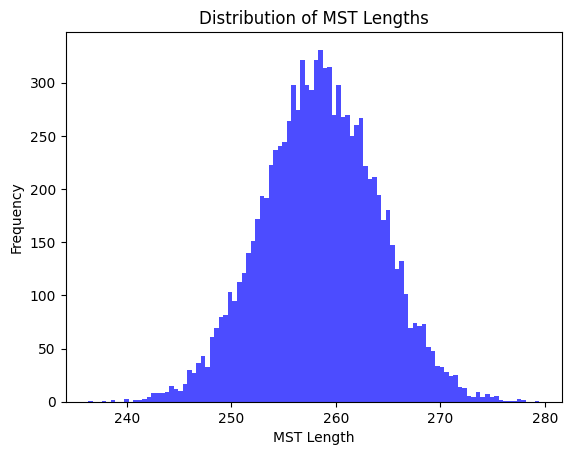

In [16]:
def modify_graph(G, std_dev=0.3):
    G_modified = G.copy()
    for (u, v, weight) in G_modified.edges(data='weight'):
        modified_weight = weight * (1 + np.random.normal(0, std_dev))
        G_modified[u][v]['weight'] = modified_weight
    return G_modified

mst_lengths = []

for _ in tqdm(range(10000)):
    G_modified = modify_graph(G2)
    mst = nx.minimum_spanning_tree(G_modified)
    mst_length = sum(weight for (u, v, weight) in mst.edges(data='weight'))
    mst_lengths.append(mst_length)

plt.hist(mst_lengths, bins=100, color='blue', alpha=0.7)
plt.title('Distribution of MST Lengths')
plt.xlabel('MST Length')
plt.ylabel('Frequency')
plt.show()

In [17]:
var_5_percent = np.percentile(mst_lengths, 95)
print(f"Value-At-Risk (VaR) at 5% level: {var_5_percent}")

Value-At-Risk (VaR) at 5% level: 267.6310088542027


#### Problem 4

100%|██████████| 321/321 [00:02<00:00, 107.19it/s]


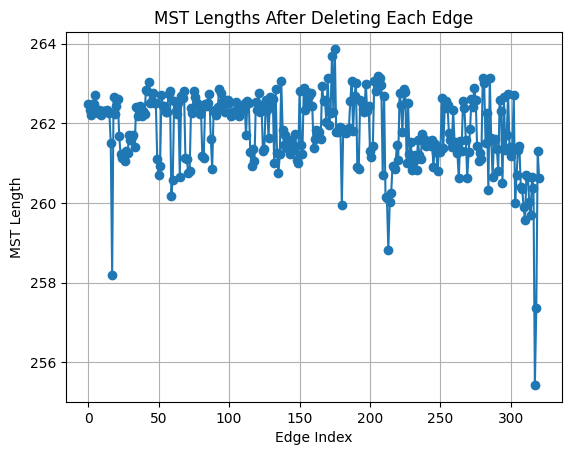

In [18]:
new_mst2_lengths = []

for edge in tqdm(mst2.edges()):
    G2_modified = G2.copy()
    G2_modified.remove_edge(*edge)
    new_mst2 = nx.minimum_spanning_tree(G2_modified)
    new_mst2_length = sum(weight for (u, v, weight) in new_mst2.edges(data='weight'))
    new_mst2_lengths.append(new_mst2_length)

plt.plot(new_mst2_lengths, marker='o', linestyle='-')
plt.title('MST Lengths After Deleting Each Edge')
plt.xlabel('Edge Index')
plt.ylabel('MST Length')
plt.grid(True)
plt.show()